In [1]:
!pip install torch==2.1.0 torchtext==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import unicodedata
import numpy as np
from gensim.utils import simple_preprocess
import re
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging
from tqdm import tqdm
tqdm.pandas()
import torch.optim as optim
print(torch.__version__)
import torch.nn.utils as nn_utils

print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

2.1.0+cu121
True


device(type='cuda')

In [3]:
import torchtext
print(torchtext.__version__)
from torchtext.data.utils import get_tokenizer

0.16.0+cpu


In [4]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [8]:
# load dataset
train = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/train.csv')
val = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/val.csv')
test = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/val.csv')

train = shuffle(train, random_state=42)
val = shuffle(val, random_state=42)
test = shuffle(test, random_state=42)

tokenizer_torchtext = get_tokenizer('basic_english')
train_sents = []
val_sents = []
test_sents = []
vocab = []

for sent in list(train['texts'].values):
    sent = unicodedata.normalize("NFKC", sent)
    train_sents.append(' '.join(tokenizer_torchtext(sent)))
    vocab.extend(tokenizer_torchtext(sent))
    
for sent in list(val['texts'].values):
    sent = unicodedata.normalize("NFKC", sent)
    val_sents.append(' '.join(tokenizer_torchtext(sent)))
    
for sent in list(test['texts'].values):
    sent = unicodedata.normalize("NFKC", sent)
    test_sents.append(' '.join(tokenizer_torchtext(sent)))
    
len_vocab = len(list(set(vocab)))
print('len_vocab separate with white space:', len_vocab)


len_vocab separate with white space: 13774


In [17]:
class TextDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Tiền xử lý dữ liệu
def preprocess_data(texts, tokenizer, max_length):
    encoding = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding['input_ids'], encoding['attention_mask']


In [18]:
total = train_sents + val_sents + test_sents
max_length = 0
for sent in total:
    if len(sent.split()) > max_length:
        max_length = len(sent.split())
    
print('maxlen: ', max_length)

maxlen:  120


In [19]:
# Tokenizer PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# Tiền xử lý dữ liệu
train_input_ids, train_attention_masks = preprocess_data(train_sents, tokenizer, max_length=max_length)
val_input_ids, val_attention_masks = preprocess_data(val_sents, tokenizer, max_length=max_length)
test_input_ids, test_attention_masks = preprocess_data(test_sents, tokenizer, max_length=max_length)


# Tạo Dataset và DataLoader
train_dataset = TextDataset(train_input_ids, train_attention_masks, list(train['labels'].values))
val_dataset = TextDataset(val_input_ids, val_attention_masks, list(val['labels'].values))
test_dataset = TextDataset(test_input_ids, test_attention_masks, list(test['labels'].values))

batch_size=120
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [20]:
for batch_idx, item in enumerate(val_loader):
    print('English Data (batch 0):', item)
    break

English Data (batch 0): {'input_ids': tensor([[    0,  3788,   575,  ...,     1,     1,     1],
        [    0,  3129,   177,  ...,     1,     1,     1],
        [    0,    15,  3464,  ...,     1,     1,     1],
        ...,
        [    0,  1701,   237,  ...,     1,     1,     1],
        [    0,    16, 10778,  ...,     1,     1,     1],
        [    0,    54,  1582,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 

In [22]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        #nn.init.normal_(self.fc.weight, std=0.02)
        #nn.init.normal_(self.fc.bias, 0)
        for param in self.bert.parameters():
            param.requires_grad = False
            
            
    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False 
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

bert = SentimentClassifier(1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(bert.parameters(), lr=0.001)  
bert

SentimentClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [23]:

class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, model, score):
        if self.best_score is None:
            self.best_score = score
            torch.save(model, '/kaggle/working/bert.pth')
            return 'save model'
        elif score > self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return 'no save model'
        else:
            self.best_score = score
            self.counter = 0
            torch.save(model, '/kaggle/working/bert.pth')
            return 'save model'

early_stopping = EarlyStopping(patience=10, delta=0.01)

In [24]:
# training and validation

def train(num_epochs):
    train_loss = []
    train_accuracy = []
    train_precision = []
    train_recall = []
    
    val_losss = []
    val_accuracys = []
    val_precisions = []
    val_recalls = []
    for epoch in range(num_epochs):
        bert.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        
        for batch_idx, data in progress_bar:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['labels'].to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = bert(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            loss = criterion(outputs, targets)
            
            # backward pass
            loss.backward()
           
            #nn_utils.clip_grad_norm_(bert.parameters(), max_norm=1.0)  # chỉ clip gradient của encoder với max_norm là 1.0
            # update parameters
            optimizer.step()
            
            # total loss
            total_loss += loss.item()
            
            preds = torch.round(torch.sigmoid(outputs)) 
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(targets.detach().cpu().numpy())
            
            # update progress bar description
            progress_bar.set_postfix({'Loss':loss.item()})
        
        # caculate avg loss
        avg_loss = total_loss / len(train_loader)
        #print('shape:',np.array(all_preds).shape, np.array(all_labels).shape)
        all_preds = np.array(all_preds).flatten()
        all_labels = np.array(all_labels).flatten()
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        
        train_loss.append(avg_loss)
        train_accuracy.append(accuracy)
        train_precision.append(precision)
        train_recall.append(recall)
        
        # validation
        bert.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            val_progress_bar = tqdm(enumerate(val_loader), total = len(val_loader), desc='Validation', unit='batch')
            
            for batch_idx, data in val_progress_bar:
                input_ids = data['input_ids'].to(device)
                attention_mask = data['attention_mask'].to(device)
                targets = data['labels'].to(device).unsqueeze(1)

                outputs = bert(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
           
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                preds = torch.round(torch.sigmoid(outputs)) 
                val_preds.extend(preds.detach().cpu().numpy())
                val_labels.extend(targets.detach().cpu().numpy())
                # update val progress_bar description
                val_progress_bar.set_postfix({'Validation loss':loss.item()})
            
            # caculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_preds = np.array(val_preds).flatten()
        val_labels = np.array(val_labels).flatten()
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds)
        val_recall = recall_score(val_labels, val_preds)
        
        val_losss.append(avg_val_loss)
        val_accuracys.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        print(f'Epoch {epoch+1}/{num_epochs}, Average loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f} \n , Validation Loss: {avg_val_loss:.4f}, val_accuracy: {val_accuracy:.4f}, val_precision: {val_precision:.4f}, val_recall: {val_recall:.4f}', early_stopping(bert, val_loss))
        
            
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return {"train_loss": train_loss,
                    "train_accuracy": train_accuracy,
                    "train_precision": train_precision,
                    "train_recall": train_recall,
                    
                    "val_loss": val_losss,
                    "val_accuracy": val_accuracys, 
                    "val_precision": val_precisions,
                    "val_recall": val_recalls}
            break
        
    return {"train_loss": train_loss,
                    "train_accuracy": train_accuracy,
                    "train_precision": train_precision,
                    "train_recall": train_recall,
                    
                    "val_loss": val_losss,
                    "val_accuracy": val_accuracys, 
                    "val_precision": val_precisions,
                    "val_recall": val_recalls}
history = train(100)

Validation: 100%|██████████| 42/42 [00:17<00:00,  2.42batch/s, Validation loss=0.573]


Epoch 1/100, Average loss: 0.6151, Accuracy: 0.7091, Precision: 0.6914, Recall: 0.7553 
 , Validation Loss: 0.5503, val_accuracy: 0.7542, val_precision: 0.8319, val_recall: 0.6372 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.42batch/s, Validation loss=0.538]


Epoch 2/100, Average loss: 0.5407, Accuracy: 0.7529, Precision: 0.7456, Recall: 0.7677 
 , Validation Loss: 0.4930, val_accuracy: 0.7938, val_precision: 0.8143, val_recall: 0.7612 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.523]


Epoch 3/100, Average loss: 0.5079, Accuracy: 0.7684, Precision: 0.7615, Recall: 0.7816 
 , Validation Loss: 0.4679, val_accuracy: 0.7944, val_precision: 0.8251, val_recall: 0.7472 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.42batch/s, Validation loss=0.519]


Epoch 4/100, Average loss: 0.4917, Accuracy: 0.7719, Precision: 0.7671, Recall: 0.7807 
 , Validation Loss: 0.4515, val_accuracy: 0.8030, val_precision: 0.8318, val_recall: 0.7596 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.516]


Epoch 5/100, Average loss: 0.4819, Accuracy: 0.7797, Precision: 0.7760, Recall: 0.7862 
 , Validation Loss: 0.4392, val_accuracy: 0.8110, val_precision: 0.8310, val_recall: 0.7808 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.515]


Epoch 6/100, Average loss: 0.4763, Accuracy: 0.7790, Precision: 0.7745, Recall: 0.7872 
 , Validation Loss: 0.4306, val_accuracy: 0.8156, val_precision: 0.8315, val_recall: 0.7916 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.511]


Epoch 7/100, Average loss: 0.4705, Accuracy: 0.7794, Precision: 0.7747, Recall: 0.7878 
 , Validation Loss: 0.4282, val_accuracy: 0.8092, val_precision: 0.8433, val_recall: 0.7596 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.51] 


Epoch 8/100, Average loss: 0.4725, Accuracy: 0.7774, Precision: 0.7769, Recall: 0.7782 
 , Validation Loss: 0.4222, val_accuracy: 0.8162, val_precision: 0.8400, val_recall: 0.7812 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.508]


Epoch 9/100, Average loss: 0.4659, Accuracy: 0.7839, Precision: 0.7811, Recall: 0.7886 
 , Validation Loss: 0.4200, val_accuracy: 0.8126, val_precision: 0.8469, val_recall: 0.7632 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.51] 


Epoch 10/100, Average loss: 0.4640, Accuracy: 0.7830, Precision: 0.7822, Recall: 0.7843 
 , Validation Loss: 0.4127, val_accuracy: 0.8200, val_precision: 0.8289, val_recall: 0.8064 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.512]


Epoch 11/100, Average loss: 0.4598, Accuracy: 0.7863, Precision: 0.7827, Recall: 0.7925 
 , Validation Loss: 0.4106, val_accuracy: 0.8210, val_precision: 0.8345, val_recall: 0.8008 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.42batch/s, Validation loss=0.508]


Epoch 12/100, Average loss: 0.4649, Accuracy: 0.7804, Precision: 0.7789, Recall: 0.7830 
 , Validation Loss: 0.4145, val_accuracy: 0.8116, val_precision: 0.8560, val_recall: 0.7492 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.513]


Epoch 13/100, Average loss: 0.4641, Accuracy: 0.7825, Precision: 0.7803, Recall: 0.7865 
 , Validation Loss: 0.4052, val_accuracy: 0.8238, val_precision: 0.8311, val_recall: 0.8128 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.509]


Epoch 14/100, Average loss: 0.4595, Accuracy: 0.7864, Precision: 0.7830, Recall: 0.7924 
 , Validation Loss: 0.4055, val_accuracy: 0.8234, val_precision: 0.8448, val_recall: 0.7924 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.511]


Epoch 15/100, Average loss: 0.4608, Accuracy: 0.7836, Precision: 0.7798, Recall: 0.7902 
 , Validation Loss: 0.4075, val_accuracy: 0.8198, val_precision: 0.8545, val_recall: 0.7708 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.51] 


Epoch 16/100, Average loss: 0.4629, Accuracy: 0.7799, Precision: 0.7775, Recall: 0.7843 
 , Validation Loss: 0.4033, val_accuracy: 0.8242, val_precision: 0.8459, val_recall: 0.7928 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.511]


Epoch 17/100, Average loss: 0.4588, Accuracy: 0.7852, Precision: 0.7825, Recall: 0.7900 
 , Validation Loss: 0.4014, val_accuracy: 0.8232, val_precision: 0.8412, val_recall: 0.7968 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.513]


Epoch 18/100, Average loss: 0.4612, Accuracy: 0.7835, Precision: 0.7792, Recall: 0.7910 
 , Validation Loss: 0.3992, val_accuracy: 0.8240, val_precision: 0.8378, val_recall: 0.8036 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.514]


Epoch 19/100, Average loss: 0.4559, Accuracy: 0.7822, Precision: 0.7788, Recall: 0.7883 
 , Validation Loss: 0.4009, val_accuracy: 0.8240, val_precision: 0.8441, val_recall: 0.7948 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.513]


Epoch 20/100, Average loss: 0.4608, Accuracy: 0.7797, Precision: 0.7767, Recall: 0.7851 
 , Validation Loss: 0.3990, val_accuracy: 0.8258, val_precision: 0.8453, val_recall: 0.7976 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.516]


Epoch 21/100, Average loss: 0.4525, Accuracy: 0.7888, Precision: 0.7852, Recall: 0.7949 
 , Validation Loss: 0.3974, val_accuracy: 0.8244, val_precision: 0.8390, val_recall: 0.8028 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.517]


Epoch 22/100, Average loss: 0.4583, Accuracy: 0.7868, Precision: 0.7845, Recall: 0.7907 
 , Validation Loss: 0.3987, val_accuracy: 0.8240, val_precision: 0.8456, val_recall: 0.7928 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.516]


Epoch 23/100, Average loss: 0.4577, Accuracy: 0.7839, Precision: 0.7831, Recall: 0.7853 
 , Validation Loss: 0.3995, val_accuracy: 0.8212, val_precision: 0.8510, val_recall: 0.7788 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.518]


Epoch 24/100, Average loss: 0.4569, Accuracy: 0.7828, Precision: 0.7802, Recall: 0.7873 
 , Validation Loss: 0.3995, val_accuracy: 0.8204, val_precision: 0.8483, val_recall: 0.7804 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.514]


Epoch 25/100, Average loss: 0.4625, Accuracy: 0.7826, Precision: 0.7790, Recall: 0.7890 
 , Validation Loss: 0.3977, val_accuracy: 0.8230, val_precision: 0.8461, val_recall: 0.7896 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.513]


Epoch 26/100, Average loss: 0.4533, Accuracy: 0.7924, Precision: 0.7895, Recall: 0.7973 
 , Validation Loss: 0.3977, val_accuracy: 0.8238, val_precision: 0.8506, val_recall: 0.7856 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.514]


Epoch 27/100, Average loss: 0.4610, Accuracy: 0.7825, Precision: 0.7811, Recall: 0.7850 
 , Validation Loss: 0.3972, val_accuracy: 0.8230, val_precision: 0.8515, val_recall: 0.7824 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.519]


Epoch 28/100, Average loss: 0.4602, Accuracy: 0.7857, Precision: 0.7840, Recall: 0.7888 
 , Validation Loss: 0.3946, val_accuracy: 0.8278, val_precision: 0.8363, val_recall: 0.8152 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.514]


Epoch 29/100, Average loss: 0.4581, Accuracy: 0.7839, Precision: 0.7794, Recall: 0.7917 
 , Validation Loss: 0.3968, val_accuracy: 0.8220, val_precision: 0.8482, val_recall: 0.7844 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.512]


Epoch 30/100, Average loss: 0.4617, Accuracy: 0.7838, Precision: 0.7800, Recall: 0.7905 
 , Validation Loss: 0.3979, val_accuracy: 0.8226, val_precision: 0.8545, val_recall: 0.7776 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.511]


Epoch 31/100, Average loss: 0.4584, Accuracy: 0.7881, Precision: 0.7877, Recall: 0.7889 
 , Validation Loss: 0.3960, val_accuracy: 0.8238, val_precision: 0.8485, val_recall: 0.7884 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.509]


Epoch 32/100, Average loss: 0.4591, Accuracy: 0.7838, Precision: 0.7804, Recall: 0.7898 
 , Validation Loss: 0.3981, val_accuracy: 0.8226, val_precision: 0.8561, val_recall: 0.7756 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.512]


Epoch 33/100, Average loss: 0.4632, Accuracy: 0.7854, Precision: 0.7809, Recall: 0.7934 
 , Validation Loss: 0.3996, val_accuracy: 0.8212, val_precision: 0.8633, val_recall: 0.7632 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.513]


Epoch 34/100, Average loss: 0.4561, Accuracy: 0.7847, Precision: 0.7807, Recall: 0.7917 
 , Validation Loss: 0.3993, val_accuracy: 0.8216, val_precision: 0.8635, val_recall: 0.7640 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.515]


Epoch 35/100, Average loss: 0.4595, Accuracy: 0.7851, Precision: 0.7824, Recall: 0.7898 
 , Validation Loss: 0.3990, val_accuracy: 0.8216, val_precision: 0.8618, val_recall: 0.7660 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.518]


Epoch 36/100, Average loss: 0.4582, Accuracy: 0.7854, Precision: 0.7847, Recall: 0.7866 
 , Validation Loss: 0.3923, val_accuracy: 0.8284, val_precision: 0.8381, val_recall: 0.8140 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.517]


Epoch 37/100, Average loss: 0.4578, Accuracy: 0.7847, Precision: 0.7822, Recall: 0.7889 
 , Validation Loss: 0.3935, val_accuracy: 0.8274, val_precision: 0.8441, val_recall: 0.8032 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.42batch/s, Validation loss=0.513]


Epoch 38/100, Average loss: 0.4534, Accuracy: 0.7871, Precision: 0.7850, Recall: 0.7907 
 , Validation Loss: 0.3937, val_accuracy: 0.8248, val_precision: 0.8461, val_recall: 0.7940 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.515]


Epoch 39/100, Average loss: 0.4566, Accuracy: 0.7837, Precision: 0.7799, Recall: 0.7905 
 , Validation Loss: 0.3935, val_accuracy: 0.8232, val_precision: 0.8459, val_recall: 0.7904 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.512]


Epoch 40/100, Average loss: 0.4593, Accuracy: 0.7845, Precision: 0.7833, Recall: 0.7866 
 , Validation Loss: 0.3970, val_accuracy: 0.8220, val_precision: 0.8620, val_recall: 0.7668 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.511]


Epoch 41/100, Average loss: 0.4596, Accuracy: 0.7826, Precision: 0.7803, Recall: 0.7867 
 , Validation Loss: 0.3934, val_accuracy: 0.8246, val_precision: 0.8536, val_recall: 0.7836 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.512]


Epoch 42/100, Average loss: 0.4560, Accuracy: 0.7856, Precision: 0.7850, Recall: 0.7865 
 , Validation Loss: 0.3912, val_accuracy: 0.8244, val_precision: 0.8385, val_recall: 0.8036 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.514]


Epoch 43/100, Average loss: 0.4544, Accuracy: 0.7873, Precision: 0.7847, Recall: 0.7918 
 , Validation Loss: 0.3906, val_accuracy: 0.8256, val_precision: 0.8383, val_recall: 0.8068 save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.514]


Epoch 44/100, Average loss: 0.4567, Accuracy: 0.7863, Precision: 0.7837, Recall: 0.7909 
 , Validation Loss: 0.3916, val_accuracy: 0.8272, val_precision: 0.8440, val_recall: 0.8028 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.516]


Epoch 45/100, Average loss: 0.4565, Accuracy: 0.7848, Precision: 0.7837, Recall: 0.7866 
 , Validation Loss: 0.3930, val_accuracy: 0.8244, val_precision: 0.8478, val_recall: 0.7908 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.516]


Epoch 46/100, Average loss: 0.4604, Accuracy: 0.7858, Precision: 0.7834, Recall: 0.7900 
 , Validation Loss: 0.3930, val_accuracy: 0.8248, val_precision: 0.8488, val_recall: 0.7904 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.517]


Epoch 47/100, Average loss: 0.4577, Accuracy: 0.7842, Precision: 0.7819, Recall: 0.7883 
 , Validation Loss: 0.3936, val_accuracy: 0.8252, val_precision: 0.8550, val_recall: 0.7832 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.516]


Epoch 48/100, Average loss: 0.4573, Accuracy: 0.7868, Precision: 0.7839, Recall: 0.7917 
 , Validation Loss: 0.3936, val_accuracy: 0.8248, val_precision: 0.8521, val_recall: 0.7860 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.518]


Epoch 49/100, Average loss: 0.4534, Accuracy: 0.7876, Precision: 0.7854, Recall: 0.7913 
 , Validation Loss: 0.3926, val_accuracy: 0.8256, val_precision: 0.8524, val_recall: 0.7876 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.519]


Epoch 50/100, Average loss: 0.4626, Accuracy: 0.7800, Precision: 0.7750, Recall: 0.7891 
 , Validation Loss: 0.3999, val_accuracy: 0.8196, val_precision: 0.8679, val_recall: 0.7540 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.522]


Epoch 51/100, Average loss: 0.4586, Accuracy: 0.7852, Precision: 0.7823, Recall: 0.7902 
 , Validation Loss: 0.3911, val_accuracy: 0.8282, val_precision: 0.8463, val_recall: 0.8020 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.519]


Epoch 52/100, Average loss: 0.4618, Accuracy: 0.7833, Precision: 0.7808, Recall: 0.7877 
 , Validation Loss: 0.3999, val_accuracy: 0.8202, val_precision: 0.8680, val_recall: 0.7552 no save model


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.43batch/s, Validation loss=0.519]

Epoch 53/100, Average loss: 0.4567, Accuracy: 0.7846, Precision: 0.7810, Recall: 0.7910 
 , Validation Loss: 0.3919, val_accuracy: 0.8270, val_precision: 0.8457, val_recall: 0.8000 no save model
Early stopping triggered


In [35]:

transformer = torch.load('/kaggle/working/bert.pth')
transformer.eval()
test_loss = 0
test_preds = []
test_labels = []

with torch.no_grad():
    test_progress_bar = tqdm(enumerate(test_loader), total = len(test_loader), desc='test', unit='batch')
    for batch_idx, data in test_progress_bar:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['labels'].to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        test_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs)) 
        test_preds.extend(preds.detach().cpu().numpy())
        test_labels.extend(targets.detach().cpu().numpy())
        # update val progress_bar description
        test_progress_bar.set_postfix({'Validation loss':loss.item()})

# caculate average validation loss
avg_test_loss = test_loss / len(test_loader)
test_preds = np.array(test_preds).flatten()
test_labels = np.array(test_labels).flatten()
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
conf_matrix = confusion_matrix(test_labels, test_preds)
print(f'Average loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')
print(f"confusion_matrix: {conf_matrix}")

test: 100%|██████████| 42/42 [00:17<00:00,  2.45batch/s, Validation loss=0.519]

Average loss: 0.3919, Accuracy: 0.8270, Precision: 0.8457, Recall: 0.8000
confusion_matrix: [[2135  365]
 [ 500 2000]]


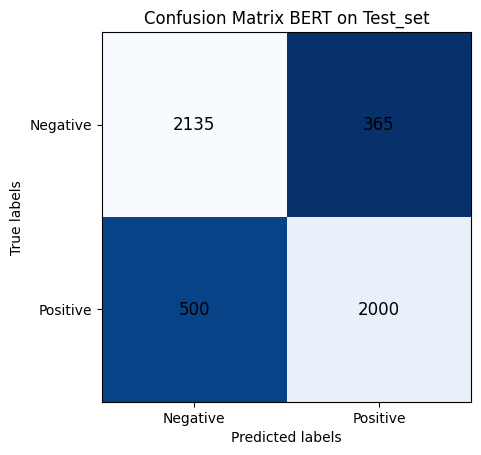

In [37]:
# plot confusion matrix with tf-idf
data = np.array([[2135, 365],
 [500, 2000]])


# plot heatmap
plt.imshow(data, cmap=plt.cm.Blues_r, interpolation='nearest')

# Điền giá trị vào từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, str(data[i, j]), fontsize=12,
                 horizontalalignment='center',
                 verticalalignment='center', color='black')

# Đặt tiêu đề và nhãn trục
plt.title('Confusion Matrix BERT on Test_set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Đặt ticks cho trục x và trục y
plt.xticks(np.arange(data.shape[1]), ['Negative', 'Positive'])
plt.yticks(np.arange(data.shape[0]), ['Negative', 'Positive'])

plt.show()

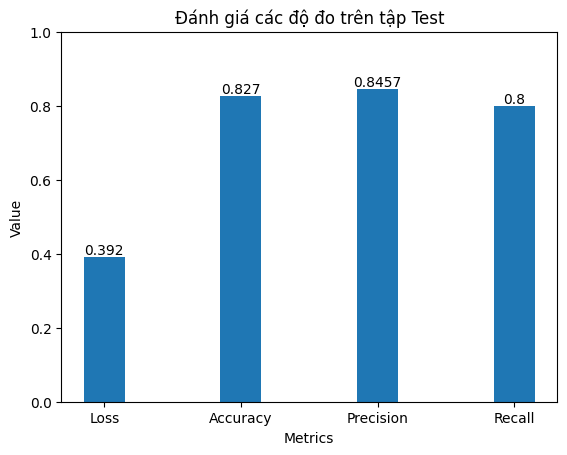

In [38]:
import matplotlib.pyplot as plt
values = [0.392,  0.8270,  0.8457, 0.8000]
labels = ['Loss', 'Accuracy', 'Precision', 'Recall']
positions = [1, 2, 3, 4]

plt.bar(positions, values, width = 0.3)
for i, j in zip(positions, values):
    plt.text(i,j, str(j), ha='center', va='bottom')

plt.title('Đánh giá các độ đo trên tập Test')
plt.ylabel('Value')
plt.xlabel('Metrics')
plt.xticks(positions, labels)
plt.ylim(0, 1)
# plt.grid()
plt.show()

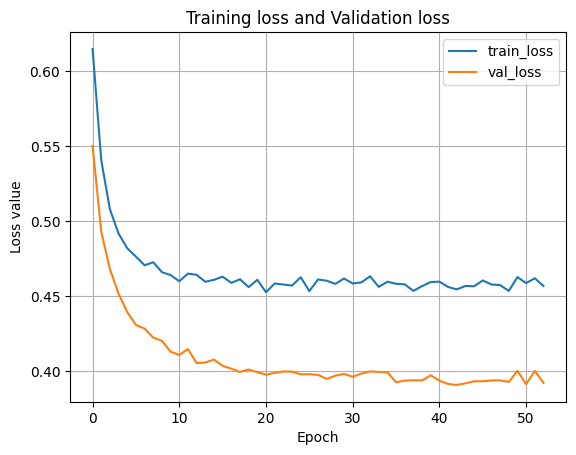

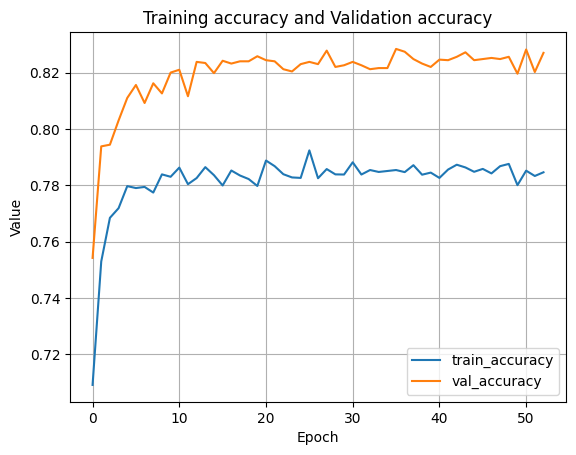

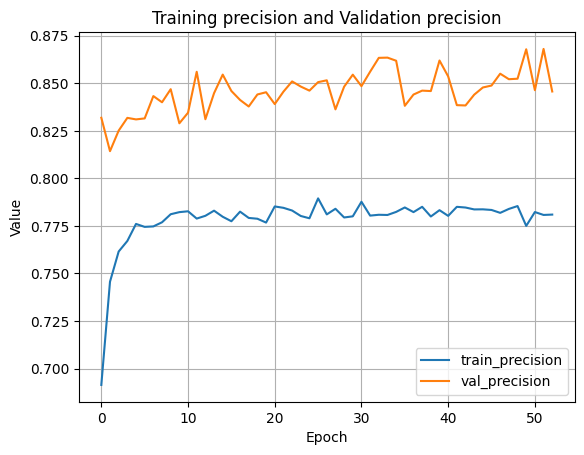

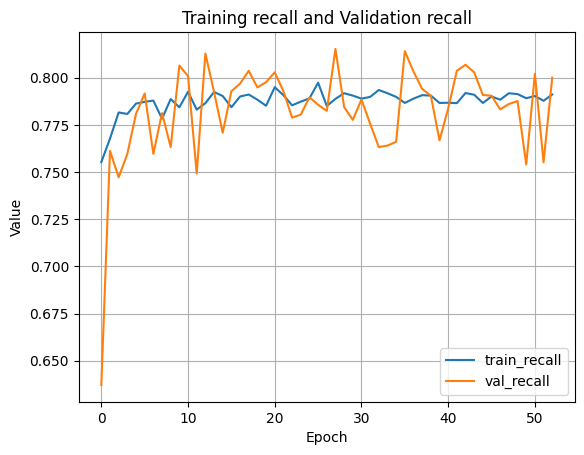

In [29]:
import matplotlib.pyplot as plt
import numpy as np

train_loss = history['train_loss']
train_accuracy = history['train_accuracy']
train_precision = history['train_precision']
train_recall = history['train_recall']
val_loss = history['val_loss']
val_accuracy = history['val_accuracy']
val_precision = history['val_precision']
val_recall = history['val_recall']

epoch = np.arange(len(val_recall))

plt.plot(train_loss, label = "train_loss")
plt.plot(val_loss, label = "val_loss")
plt.title('Training loss and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

plt.plot(train_accuracy, label = "train_accuracy")
plt.plot(val_accuracy, label = "val_accuracy")
plt.title('Training accuracy and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

plt.plot(train_precision, label = "train_precision")
plt.plot(val_precision, label = "val_precision")
plt.title('Training precision and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

plt.plot(train_recall, label = "train_recall")
plt.plot(val_recall, label = "val_recall")
plt.title('Training recall and Validation recall')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()
